In [25]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
os.environ["LANGSMITH_PROJECT"]="TestProject"

In [27]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"


In [28]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002067EE83110>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002067EF4D950>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [29]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [30]:
## Graph With tool Call
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b
tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}


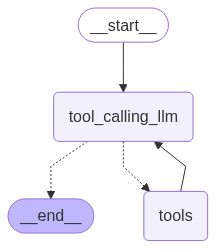

In [31]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
response=graph.invoke({"messages":"What is machine learning"})

In [33]:
response

{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='d54ac120-5770-4b7d-833a-693cce37cc4f'),
  AIMessage(content="Machine learning is a subset of artificial intelligence (AI) that involves training algorithms to recognize patterns and make predictions or decisions based on data. It's a type of computer science that allows software to improve its performance on a task without being explicitly programmed for that task.\n\nMachine learning algorithms work by analyzing large amounts of data and identifying relationships, trends, and patterns within that data. They can then use this information to make predictions, classify new data, or make decisions without being explicitly programmed to do so.\n\nThere are several types of machine learning, including:\n\n1. Supervised learning: In this type of learning, the algorithm is trained on labeled data, where the correct output is already known. The algorithm learns to map inputs to output

In [34]:

print(response['messages'][-1].content)

Machine learning is a subset of artificial intelligence (AI) that involves training algorithms to recognize patterns and make predictions or decisions based on data. It's a type of computer science that allows software to improve its performance on a task without being explicitly programmed for that task.

Machine learning algorithms work by analyzing large amounts of data and identifying relationships, trends, and patterns within that data. They can then use this information to make predictions, classify new data, or make decisions without being explicitly programmed to do so.

There are several types of machine learning, including:

1. Supervised learning: In this type of learning, the algorithm is trained on labeled data, where the correct output is already known. The algorithm learns to map inputs to outputs based on the labeled data.
2. Unsupervised learning: In this type of learning, the algorithm is trained on unlabeled data, and it must find patterns or structure within the dat

In [36]:
response=graph.invoke({"messages":"what is 5 plus 20"})

In [37]:
response

{'messages': [HumanMessage(content='what is 5 plus 20', additional_kwargs={}, response_metadata={}, id='7da48e47-5879-44f3-aa0e-38343a63af65'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7qnvqg8we', 'function': {'arguments': '{"a":5,"b":20}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 898, 'total_tokens': 970, 'completion_time': 0.060733417, 'prompt_time': 0.099746902, 'queue_time': 0.37344911599999997, 'total_time': 0.160480319}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ee55c229-f729-45f7-8aa5-9a13e3fbc247-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 20}, 'id': '7qnvqg8we', 'type': 'tool_call'}], usage_metadata={'input_tokens': 898, 'output_tokens': 72, 'total_tokens': 970}),
  ToolMessage(content='25.0', name='add', id='0fe37d69-f981-466a-822f-df64cf21c2c5', tool_call_id='7qnvqg8we'),
  AIMess

In [38]:

print(response['messages'][-1].content)

The answer is 30.0.
